# 探索数据

- 用户特征
- 视频特征
- 交互数据

基本探索思路：
1. 加载数据，检查能否正常加载数据
2. 查看数据基本信息，如有哪些数据列(`df.columns`)，数据的形状(`df.shape`)，数据列的类型(`df.dtypes`或`df.info()`)，数据的基本统计信息(`df.describe()`)
3. 处理null值，填补null值或者丢弃null值所在的行
4. 删除重复数据
5. 检查各个列(属性)的分布，可以通过画图来分析

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
from collections import Counter
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import StandardScaler
import datatable as dt

pd.set_option('display.float_format', lambda x: f"{x:.3f}")

In [3]:
base_dir = "./2021_3_data"
test_data_dir  = os.path.join(base_dir, "testdata")
train_data_dir = os.path.join(base_dir, "traindata")

In [4]:
train_dirs = os.listdir(train_data_dir)
test_dirs  = os.listdir(test_data_dir)
print(train_dirs,'\n', test_dirs)

['all_actions.npz', 'user_features_data', 'all_actions_with_ptd.npz', 'video_features_data', 'all_actions_with_ptd.jay', 'train.jay', 'all_actions.jay', 'user_context', 'train_with_status.jay', 'all_actions_with_status.jay', 'history_behavior_data', 'train.npz', '.ipynb_checkpoints'] 
 ['test.npz', 'test.csv', 'test_with_status.jay', 'test.jay', '.ipynb_checkpoints']


## 用户特征
**注意**：`user_id`是无序的

In [5]:
# 加载数据
user_data = pd.read_csv(os.path.join(train_data_dir, "user_features_data/user_features_data.csv"), delimiter="\t")

In [5]:
# 查看数据基本信息
print(user_data.columns.tolist())
print(user_data.shape)
user_data.head(5)

['user_id', 'age', 'gender', 'country', 'province', 'city', 'city_level', 'device_name']
(5910800, 8)


,user_id,age,gender,country,province,city,city_level,device_name
0,1757005,3,1,0,9,6,3,327
1,17938,0,0,0,4,22,3,327
2,4263520,1,0,0,19,1,5,327
3,1411600,3,0,0,5,138,1,327
4,3992242,2,0,0,0,142,0,327


In [344]:
user_data.info()
user_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5910800 entries, 0 to 5910799
Data columns (total 8 columns):
 #   Column       Dtype
---  ------       -----
 0   user_id      int64
 1   age          int64
 2   gender       int64
 3   country      int64
 4   province     int64
 5   city         int64
 6   city_level   int64
 7   device_name  int64
dtypes: int64(8)
memory usage: 360.8 MB


,user_id,age,gender,country,province,city,city_level,device_name
count,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000
mean,2955399.500,1.886,0.285,0.001,9.176,86.034,2.057,72.104
std,1706301.130,1.564,0.478,0.030,7.878,81.779,1.662,79.275
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1477699.750,0.000,0.000,0.000,2.000,17.000,1.000,17.000
50%,2955399.500,2.000,0.000,0.000,7.000,59.000,2.000,46.000
75%,4433099.250,3.000,1.000,0.000,15.000,137.000,3.000,102.000
max,5910799.000,7.000,3.000,2.000,32.000,338.000,7.000,1825.000


In [345]:
col_null = user_data.apply(lambda x: sum(x.isnull()), axis=0)
# row_null = user_data.apply(lambda x: sum(x.isnull()), axis=1)

In [346]:
print(f"各列中存在null值的数量：\n{col_null}")
# print(f"存在null值的行数：{sum(row_null != 0)}")

各列中存在null值的数量：
user_id        0
age            0
gender         0
country        0
province       0
city           0
city_level     0
device_name    0
dtype: int64


In [347]:
# 丢弃重复的行
user_data.drop_duplicates(inplace=True)

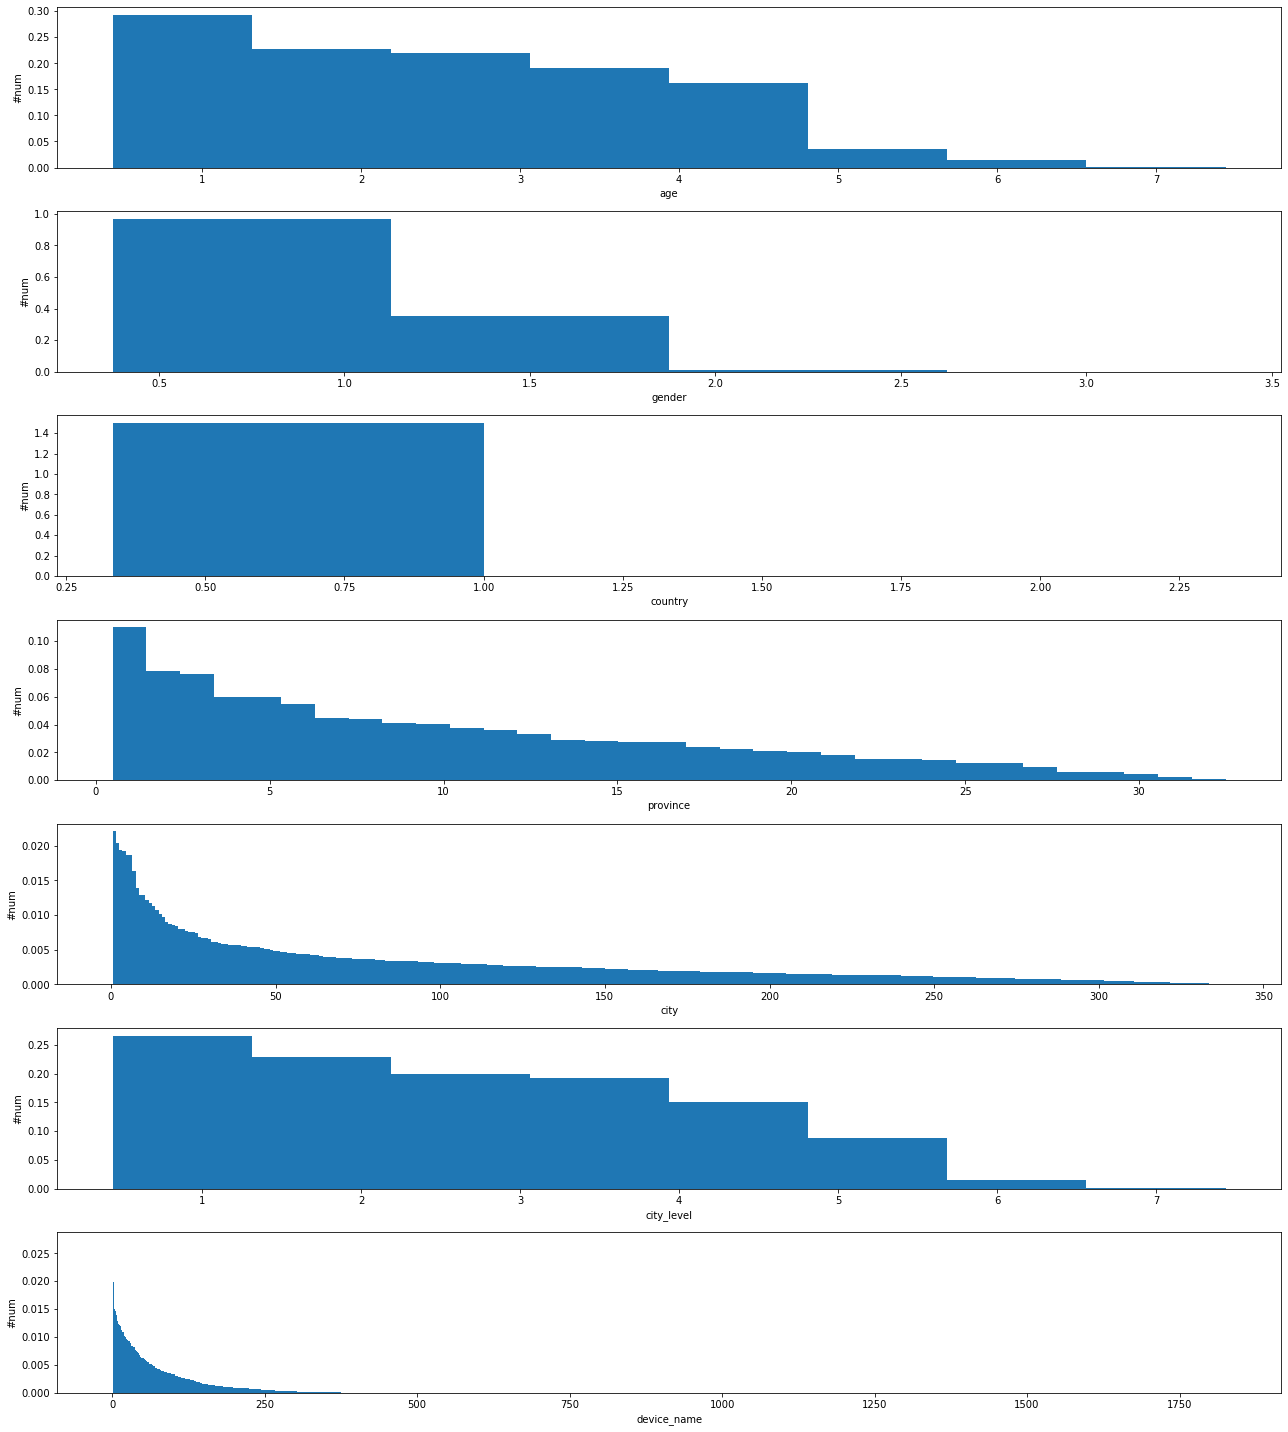

In [38]:
# 分析各个特征的分布
cols = user_data.columns.tolist()[1:]  # 去掉id列
fid, axes = plt.subplots(len(cols), 1, figsize=(18,20))

for idx, col in enumerate(cols):
    bins = len(user_data[col].unique())
    n, *_ = axes[idx].hist(user_data[col], bins=bins, align='right', density=True, log=False)
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel("#num")
#     print(f"{col} : {Counter(user_data[col])}, {[e/sum(n) for e in n]}")

plt.tight_layout()
plt.show()

## 视频特征
**注意**：`video_id`并不是连续的

In [22]:
video_data = pd.read_csv(os.path.join(train_data_dir, "video_features_data/video_features_data.csv"))

In [7]:
print(video_data.shape)
print(video_data.columns.tolist())
video_data.head(5)

(50355, 10)
['video_id', 'video_name', 'video_tags', 'video_description', 'video_release_date', 'video_director_list', 'video_actor_list', 'video_score', 'video_second_class', 'video_duration']


,video_id,video_name,video_tags,video_description,video_release_date,video_director_list,video_actor_list,video_score,video_second_class,video_duration
0,3460,脱皮爸爸,"院线电影,家庭关系,命运","中年失意的儿子田力行（古天乐饰）在生活上遇到了重重危机：母亲病逝,工作不顺,妻子要求离婚。正...",2017-04-27,司徒慧焯,"吴镇宇,古天乐,春夏,蔡洁",7.400,"剧情,喜剧,奇幻",5913
1,14553,喜气洋洋小金莲,"古装喜剧,剧情片,喜剧片,内地电影,欢乐喜剧,爱情纠纷",故事始于西门庆为西门药业的“伟哥”产品寻找代言人，西门庆初见潘金莲，一时惊为天人，为成功抱得...,2015-12-30,"杨珊珊,李亚玲","陈南飞,程隆妮,王闯,贾海涛,闫薇儿",5.600,喜剧,6217
2,1214,风流家族,"男女关系,家庭关系,命运,院线电影",香世仁（钟镇涛 饰）是家财万贯的香港富豪，在满足了一切物质上的要求后，他将生活的重心放在了儿...,2002-03-07,"邱礼涛,杨漪珊","张家辉,卢巧音,钟镇涛,叶童,李蕙敏,张坚庭,袁洁莹,黄佩霞,齐芷瑶,刘以达,叶伟信,邹凯光...",6.800,"都市,喜剧,爱情,家庭",5963
3,30639,大提琴的故事,"短片,动画片",低音大提琴演奏家史密斯科夫正要去参加某贵族的沙龙，途中他被河边的美丽景色所吸引，驻足观看。兴...,1949-01-01,"伊里·特恩卡,契诃夫",NaN,NaN,"动画,爱情",17371
4,38522,歌舞大王齐格飞,"喜剧片,人物传记,浪漫爱情",罗伯特．Z．伦纳德导演的这部影片以百老汇最大的歌舞团——齐格菲歌舞团的创办人佛罗伦斯．齐格菲...,1936-04-08,"罗伯特·Z·伦纳德,William Anthony McGuire","威廉·鲍威尔,玛娜·洛伊,路易丝·赖纳,弗兰克·摩根,范妮·布莱斯,弗吉尼亚·布鲁斯,雷吉纳...",7.700,"剧情,歌舞,喜剧",10608


In [8]:
video_data.info()
video_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50355 entries, 0 to 50354
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   video_id             50355 non-null  int64  
 1   video_name           50346 non-null  object 
 2   video_tags           42366 non-null  object 
 3   video_description    50159 non-null  object 
 4   video_release_date   49681 non-null  object 
 5   video_director_list  39217 non-null  object 
 6   video_actor_list     40035 non-null  object 
 7   video_score          46994 non-null  float64
 8   video_second_class   44364 non-null  object 
 9   video_duration       50355 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 3.8+ MB


,video_id,video_score,video_duration
count,50355.000,46994.000,50355.000
mean,25177.000,7.361,3676.101
std,14536.381,0.820,2862.891
min,0.000,5.000,0.000
25%,12588.500,7.000,148.000
50%,25177.000,7.400,5030.000
75%,37765.500,7.900,5818.000
max,50354.000,9.800,23536.000


In [9]:
col_null = video_data.apply(lambda x: sum(x.isnull()), axis=0)

In [10]:
col_null / video_data.shape[0]

video_id              0.000
video_name            0.000
video_tags            0.159
video_description     0.004
video_release_date    0.013
video_director_list   0.221
video_actor_list      0.205
video_score           0.067
video_second_class    0.119
video_duration        0.000
dtype: float64

## 交互数据
用户历史行为数据中有243个`video_id`没有在视频特征中出现

In [55]:
action_dirs = os.listdir(os.path.join(train_data_dir, "history_behavior_data"))
action_files = {e: os.listdir(os.path.join(train_data_dir, f"history_behavior_data/{e}"))[0] for e in action_dirs}
print(action_files)

{'20210420': 'part-00000-aad75aa4-b60b-4f5b-8def-c4d60f391fae-c000.csv', '20210419': 'part-00000-236b99d5-456a-42b2-bd8d-3cbd61d21cc6-c000.csv', '20210502': 'part-00000-d412c602-2f4a-4649-a81f-e56435dd49fd-c000.csv', '20210429': 'part-00000-c5dbd994-54d7-4734-adea-0f22d75b23d3-c000.csv', '20210501': 'part-00000-56b6f0ff-57b8-41ac-96ec-c20e3306297e-c000.csv', '20210422': 'part-00000-3d97d0f8-2572-45e6-bb60-f367c97e7870-c000.csv', '20210428': 'part-00000-fc8c8ca1-e655-4a45-b179-c8d9e2dd804c-c000.csv', '20210426': 'part-00000-0d315342-3ba7-4727-b4a2-123a1a004786-c000.csv', '20210427': 'part-00000-9132ab46-51c3-4cc3-97de-e7ad5312b852-c000.csv', '20210430': 'part-00000-2da4c3a0-2fcc-422d-8b7c-48940da315ad-c000.csv', '20210423': 'part-00000-9809d73a-a55f-4ac2-a59b-9b83cbc5028e-c000.csv', '20210421': 'part-00000-c15f29da-6b1e-48c0-b7d0-2cd560998c3f-c000.csv', '20210425': 'part-00000-9d23862b-6bbf-48c6-a598-572df1359737-c000.csv', '20210424': 'part-00000-225e55dc-4504-4c14-b289-322312355b2b-c0

In [8]:
i = action_dirs[1]
action_data = pd.read_csv(os.path.join(train_data_dir, f"history_behavior_data/{i}/{action_files[i]}"), delimiter="\t")

d:\codeprograms\python37\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
print(action_data.shape)
print(action_data.columns.tolist())
action_data.head(5)

(5511348, 9)
['user_id', 'video_id', 'is_watch', 'is_share', 'is_collect', 'is_comment', 'watch_start_time', 'watch_label', 'pt_d']


,user_id,video_id,is_watch,is_share,is_collect,is_comment,watch_start_time,watch_label,pt_d
0,2543081,5035,0,0,0,0,NaN,0,20210420
1,2543081,9527,0,0,0,0,NaN,0,20210420
2,2543081,3717,0,0,0,0,NaN,0,20210420
3,2543081,37417,0,0,0,0,NaN,0,20210420
4,2543081,28368,0,0,0,0,NaN,0,20210420


In [67]:
# watch_start_time为nan的行中，is_watch均为0。但是is_collect、is_comment、is_share
action_data[action_data['is_watch'].isnull()]['watch_start_time'].sum()

0

In [399]:
action_data.info()
# action_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5511348 entries, 0 to 5511347
Data columns (total 9 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   user_id           int64 
 1   video_id          int64 
 2   is_watch          int64 
 3   is_share          int64 
 4   is_collect        int64 
 5   is_comment        int64 
 6   watch_start_time  object
 7   watch_label       int64 
 8   pt_d              int64 
dtypes: int64(8), object(1)
memory usage: 378.4+ MB


In [400]:
# 按照 (user_id, video_id)进行分组。绝大部分用户基本只看了一个视频
d = action_data.duplicated(['user_id', 'video_id'])

In [401]:
d = d[d]
print(f"重复的(user_id, video_id)数量 : {d.shape[0]} ({d.shape[0]/action_data.shape[0]})")

重复的(user_id, video_id)数量 : 25 (4.536095343643697e-06)


In [402]:
# 统计每个用户的行为数目
# nu = action_data['user_id']

In [403]:
col_null = action_data.apply(lambda x: sum(x.isnull()), axis=0)

In [404]:
col_null / action_data.shape[0] # 可见，watch_start_time大部分都为NaN

user_id            0.000
video_id           0.000
is_watch           0.000
is_share           0.000
is_collect         0.000
is_comment         0.000
watch_start_time   0.907
watch_label        0.000
pt_d               0.000
dtype: float64

In [23]:
# 删除列
action_data.drop('watch_start_time', inplace=True, axis=1)
action_data.drop('pt_d', inplace=True, axis=1)

is_watch : Counter({0: 5000945, 1: 510403}), [0.907, 0.093]
is_share : Counter({0: 5510400, 1: 948}), [1.0, 0.0]
is_collect : Counter({0: 5505237, 1: 6111}), [0.999, 0.001]
is_comment : Counter({0: 5510385, 1: 963}), [1.0, 0.0]
watch_label : Counter({0: 5363875, 1: 36171, 9: 28097, 2: 20349, 3: 14991, 4: 11810, 5: 9820, 8: 9375, 6: 8793, 7: 8067}), [0.973, 0.007, 0.004, 0.003, 0.002, 0.002, 0.002, 0.001, 0.002, 0.005]


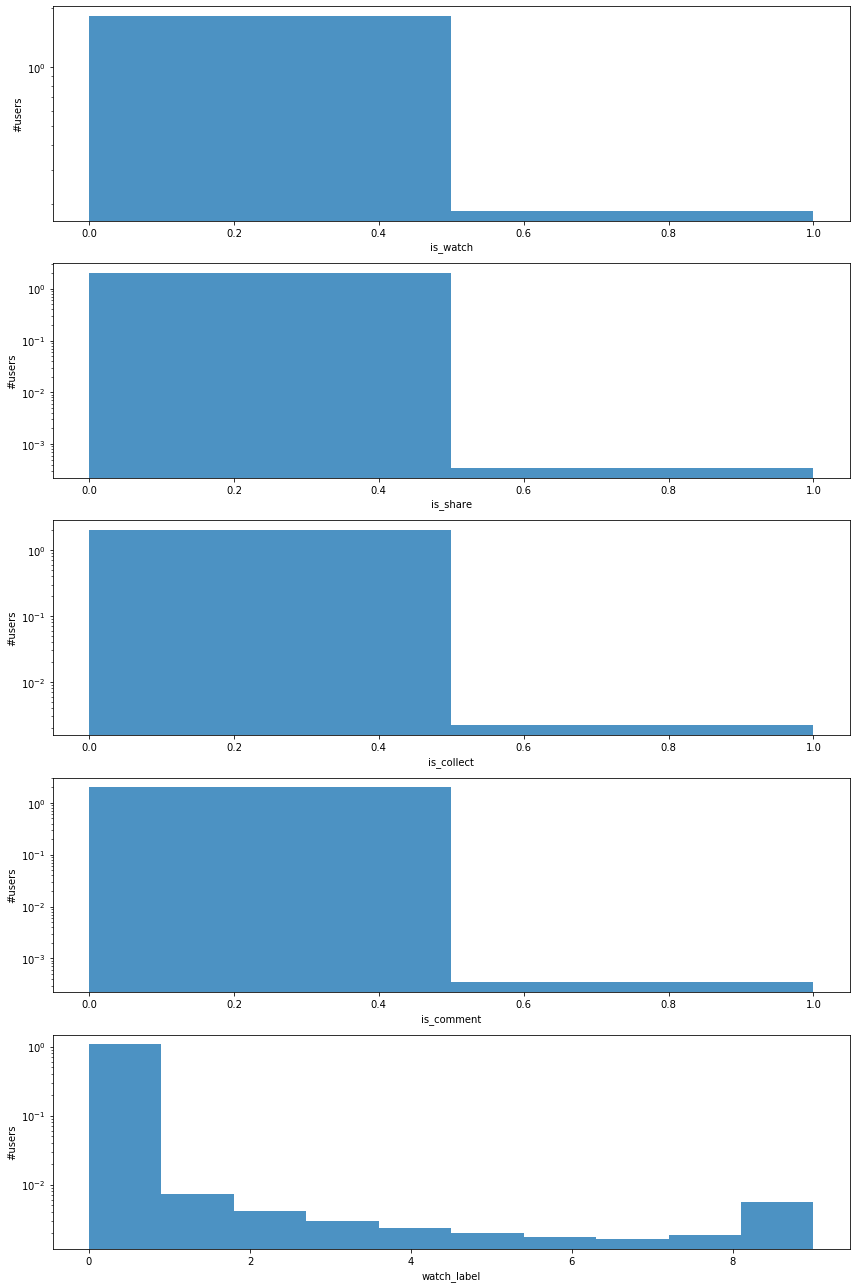

In [53]:
# 分析各个特征的分布
cols = action_data.columns.tolist()[2:]  # 去掉id列
# cols.remove('watch_start_time')
# cols.remove('pt_d')
fid, axes = plt.subplots(len(cols), 1, figsize=(12,18))



for idx, col in enumerate(cols):
    bins = len(action_data[col].unique())
    n, *_ = axes[idx].hist(action_data[col], bins=bins, align='mid', density=True, alpha=0.8, log=True)
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel("#users")
    print(f"{col} : {Counter(action_data[col])}, {[round(e/sum(n), 3) for e in n]}")

plt.tight_layout()
plt.show()

## 测试数据

In [51]:
test_data = pd.read_csv(os.path.join(test_data_dir, "test.csv"))

In [57]:
# 测试数据集中存在video_id没有在视频特征中出现
idx1 = pd.Index(test_data['video_id'].unique())
idx2 = pd.Index(video_data['video_id'].unique())
non_exists = idx1.difference(idx2)

In [60]:
t0 = time()
n = 0
for vid in non_exists:
    tn = (test_data['video_id'] == vid).sum()
    n += tn

print(f"在视频特征中没出现过video_id数量 = {len(non_exists)}\t共占 {n}行\t\t({time()-t0:.3f}s)")

在视频特征中没出现过video_id数量 = 276	共占 22219行		(1.230s)


In [26]:
print(test_data.shape)
print(test_data.columns.tolist())
test_data.head(5)

(2822180, 2)
['user_id', 'video_id']


,user_id,video_id
0,1688013,32645
1,4502598,41270
2,5585629,16345
3,1635520,28149
4,4160191,40554


In [27]:
print(f"unique users  : {len(test_data['user_id'].unique())}")
print(f"unique videos : {len(test_data['video_id'].unique())}")

unique users  : 492174
unique videos : 23686


In [28]:
# 检查测试数据中的(user_id, video_id)是否出现在历史行为数据中
pd.merge(action_data, test_data, on=['user_id', 'video_id'], how='inner')

,user_id,video_id,is_watch,is_share,is_collect,is_comment,watch_label
0,4206081,12968,0,0,0,0,0
1,2828977,1759,0,0,0,0,0
2,3861990,23410,0,0,0,0,0
3,1093230,29453,0,0,0,0,0
4,1093230,28413,0,0,0,0,0
...,...,...,...,...,...,...,...
26767,3944251,50299,1,0,1,1,0
26768,5614611,47507,1,0,0,0,0
26769,5614611,15888,1,0,0,0,7
26770,3218613,5601,1,0,0,0,7


In [29]:
action_data[(action_data['user_id'] == 1869184) & (action_data['video_id'] == 12968)]

,user_id,video_id,is_watch,is_share,is_collect,is_comment,watch_label


In [30]:
test_data[(test_data['user_id'] == 1869184) & (test_data['video_id'] == 12968)]

,user_id,video_id
951388,1869184,12968


# 生成初步的特征矩阵

## 用户特征矩阵

In [6]:
user_data

,user_id,age,gender,country,province,city,city_level,device_name
0,1757005,3,1,0,9,6,3,327
1,17938,0,0,0,4,22,3,327
2,4263520,1,0,0,19,1,5,327
3,1411600,3,0,0,5,138,1,327
4,3992242,2,0,0,0,142,0,327
...,...,...,...,...,...,...,...,...
5910795,3223427,4,0,0,3,3,3,28
5910796,4707826,4,0,0,17,249,1,28
5910797,5907653,0,0,0,11,65,0,28
5910798,3633224,3,0,0,2,57,1,28


In [7]:
# 各特征的基数
cols = user_data.columns[1:]
for col in cols:
    print(f"{col:12} : {user_data[col].unique().shape[0]:^6}")

age          :   8   
gender       :   4   
country      :   3   
province     :   33  
city         :  339  
city_level   :   8   
device_name  :  1826 


### 用户数据中类别特征的转化

基数很大的类别特征['province', 'city', 'device_name']

- 删除以下列：`['province', 'city']`
- 展开为one-hot：`['age', 'gender', 'city_level']`
- 用 FeatureHasher处理：`['device_name']`


In [8]:
del_cols = [ 'city', 'country']
for dc in del_cols: 
    user_data.drop([dc], axis=1, inplace=True)
    
user_data.head(5)

,user_id,age,gender,province,city_level,device_name
0,1757005,3,1,9,3,327
1,17938,0,0,4,3,327
2,4263520,1,0,19,5,327
3,1411600,3,0,5,1,327
4,3992242,2,0,0,0,327


In [10]:
onehot_cols = ['age', 'gender', 'city_level', 'province']

for oc in onehot_cols:
    df = user_data[oc]
    tmp_df = pd.get_dummies(df)
    cols = tmp_df.columns
    tmp_df.columns = [f"{oc}_{col}" for col in cols]
    user_data = pd.concat([user_data, tmp_df], axis=1)
    print(f"{oc} processed ...")
    user_data.drop([oc], axis=1, inplace=True)
    del tmp_df
user_data.head(5)

age processed ...
gender processed ...
city_level processed ...
province processed ...


,user_id,device_name,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_7,...,province_23,province_24,province_25,province_26,province_27,province_28,province_29,province_30,province_31,province_32
0,1757005,327,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,17938,327,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4263520,327,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1411600,327,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3992242,327,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
fh_cols = ['device_name']
n_feats = [10]
for idx, fc in enumerate(fh_cols):
#     df = user_data[fc]
    fea_hs = FeatureHasher(n_features=n_feats[idx], input_type='string')
    hasherd = fea_hs.fit_transform(user_data[fc].astype('str'))
    tmp_df = pd.DataFrame(hasherd.toarray(), columns=[f"{fc}_{i}" for i in range(n_feats[idx])])
    user_data = pd.concat([user_data, tmp_df], axis=1)
    print(f"{fc} processed ...")
    user_data.drop([fc], axis=1, inplace=True)
    del hasherd
    
user_data.head(5)

device_name processed ...


,user_id,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_7,gender_0,...,device_name_0,device_name_1,device_name_2,device_name_3,device_name_4,device_name_5,device_name_6,device_name_7,device_name_8,device_name_9
0,1757005,0,0,0,1,0,0,0,0,0,...,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
1,17938,1,0,0,0,0,0,0,0,1,...,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
2,4263520,0,1,0,0,0,0,0,0,1,...,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
3,1411600,0,0,0,1,0,0,0,0,1,...,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
4,3992242,0,0,1,0,0,0,0,0,1,...,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000


In [354]:
user_data.describe()

,user_id,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_7,gender_0,...,device_name_0,device_name_1,device_name_2,device_name_3,device_name_4,device_name_5,device_name_6,device_name_7,device_name_8,device_name_9
count,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,...,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000
mean,2955399.500,0.257,0.198,0.192,0.167,0.142,0.031,0.013,0.001,0.726,...,0.567,0.431,-0.193,-0.146,0.000,0.000,0.000,-0.442,0.155,-0.159
std,1706301.130,0.437,0.399,0.394,0.373,0.349,0.173,0.112,0.029,0.446,...,0.646,0.599,0.419,0.367,0.000,0.000,0.000,0.610,0.378,0.378
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,-3.000,-3.000,0.000,0.000,0.000,-4.000,0.000,-3.000
25%,1477699.750,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,0.000,0.000
50%,2955399.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,4433099.250,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,...,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
max,5910799.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,3.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000


### 对特征列进行标准化

In [11]:
cols = user_data.columns[1:]
scaler = StandardScaler()
data = user_data[cols]
scaler.fit(data)
sca_data = scaler.transform(data)

In [12]:
user_data[cols] = sca_data

In [13]:
user_data.head(10)

,user_id,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_7,gender_0,...,device_name_0,device_name_1,device_name_2,device_name_3,device_name_4,device_name_5,device_name_6,device_name_7,device_name_8,device_name_9
0,1757005,-0.588,-0.497,-0.487,2.235,-0.407,-0.178,-0.113,-0.029,-1.628,...,0.670,0.950,0.462,0.396,0.000,0.000,0.000,0.725,2.237,0.421
1,17938,1.701,-0.497,-0.487,-0.448,-0.407,-0.178,-0.113,-0.029,0.614,...,0.670,0.950,0.462,0.396,0.000,0.000,0.000,0.725,2.237,0.421
2,4263520,-0.588,2.011,-0.487,-0.448,-0.407,-0.178,-0.113,-0.029,0.614,...,0.670,0.950,0.462,0.396,0.000,0.000,0.000,0.725,2.237,0.421
3,1411600,-0.588,-0.497,-0.487,2.235,-0.407,-0.178,-0.113,-0.029,0.614,...,0.670,0.950,0.462,0.396,0.000,0.000,0.000,0.725,2.237,0.421
4,3992242,-0.588,-0.497,2.052,-0.448,-0.407,-0.178,-0.113,-0.029,0.614,...,0.670,0.950,0.462,0.396,0.000,0.000,0.000,0.725,2.237,0.421
5,4011597,-0.588,-0.497,2.052,-0.448,-0.407,-0.178,-0.113,-0.029,0.614,...,0.670,0.950,0.462,0.396,0.000,0.000,0.000,0.725,2.237,0.421
6,4785561,-0.588,-0.497,-0.487,-0.448,-0.407,5.618,-0.113,-0.029,-1.628,...,0.670,0.950,0.462,0.396,0.000,0.000,0.000,0.725,2.237,0.421
7,5110362,1.701,-0.497,-0.487,-0.448,-0.407,-0.178,-0.113,-0.029,0.614,...,0.670,0.950,0.462,0.396,0.000,0.000,0.000,0.725,2.237,0.421
8,1321200,-0.588,-0.497,-0.487,-0.448,-0.407,5.618,-0.113,-0.029,-1.628,...,0.670,0.950,0.462,0.396,0.000,0.000,0.000,0.725,2.237,0.421
9,3206983,1.701,-0.497,-0.487,-0.448,-0.407,-0.178,-0.113,-0.029,-1.628,...,0.670,0.950,0.462,0.396,0.000,0.000,0.000,0.725,2.237,0.421


In [12]:
user_data.info()
user_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5910800 entries, 0 to 5910799
Data columns (total 64 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        int64  
 1   age_0          uint8  
 2   age_1          uint8  
 3   age_2          uint8  
 4   age_3          uint8  
 5   age_4          uint8  
 6   age_5          uint8  
 7   age_6          uint8  
 8   age_7          uint8  
 9   gender_0       uint8  
 10  gender_1       uint8  
 11  gender_2       uint8  
 12  gender_3       uint8  
 13  city_level_0   uint8  
 14  city_level_1   uint8  
 15  city_level_2   uint8  
 16  city_level_3   uint8  
 17  city_level_4   uint8  
 18  city_level_5   uint8  
 19  city_level_6   uint8  
 20  city_level_7   uint8  
 21  province_0     uint8  
 22  province_1     uint8  
 23  province_2     uint8  
 24  province_3     uint8  
 25  province_4     uint8  
 26  province_5     uint8  
 27  province_6     uint8  
 28  province_7     uint8  
 29  province_8    

,user_id,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_7,gender_0,...,device_name_0,device_name_1,device_name_2,device_name_3,device_name_4,device_name_5,device_name_6,device_name_7,device_name_8,device_name_9
count,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,...,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000
mean,2955399.500,0.257,0.198,0.192,0.167,0.142,0.031,0.013,0.001,0.726,...,0.567,0.431,-0.193,-0.146,0.000,0.000,0.000,-0.442,0.155,-0.159
std,1706301.130,0.437,0.399,0.394,0.373,0.349,0.173,0.112,0.029,0.446,...,0.646,0.599,0.419,0.367,0.000,0.000,0.000,0.610,0.378,0.378
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,-3.000,-3.000,0.000,0.000,0.000,-4.000,0.000,-3.000
25%,1477699.750,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,0.000,0.000
50%,2955399.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,4433099.250,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,...,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
max,5910799.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,3.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000


### 保存用户特征矩阵

In [14]:
# 保存数据
data = user_data.values
cols = user_data.columns
np.savez(os.path.join(train_data_dir, "user_features_data/user_features_v1"), features=data, columns=cols)

In [15]:
user_data.to_csv(os.path.join(train_data_dir, "user_features_data/user_features_v1.csv"), index=False)

In [20]:
import datatable as dt
tab = dt.fread(os.path.join(train_data_dir, "user_features_data/user_features_v1.csv"))
tab.to_jay(os.path.join(train_data_dir, "user_features_data/user_features_v1.jay"))

## 视频特征矩阵

In [23]:
video_data.head()

,video_id,video_name,video_tags,video_description,video_release_date,video_director_list,video_actor_list,video_score,video_second_class,video_duration
0,3460,脱皮爸爸,"院线电影,家庭关系,命运","中年失意的儿子田力行（古天乐饰）在生活上遇到了重重危机：母亲病逝,工作不顺,妻子要求离婚。正...",2017-04-27,司徒慧焯,"吴镇宇,古天乐,春夏,蔡洁",7.400,"剧情,喜剧,奇幻",5913
1,14553,喜气洋洋小金莲,"古装喜剧,剧情片,喜剧片,内地电影,欢乐喜剧,爱情纠纷",故事始于西门庆为西门药业的“伟哥”产品寻找代言人，西门庆初见潘金莲，一时惊为天人，为成功抱得...,2015-12-30,"杨珊珊,李亚玲","陈南飞,程隆妮,王闯,贾海涛,闫薇儿",5.600,喜剧,6217
2,1214,风流家族,"男女关系,家庭关系,命运,院线电影",香世仁（钟镇涛 饰）是家财万贯的香港富豪，在满足了一切物质上的要求后，他将生活的重心放在了儿...,2002-03-07,"邱礼涛,杨漪珊","张家辉,卢巧音,钟镇涛,叶童,李蕙敏,张坚庭,袁洁莹,黄佩霞,齐芷瑶,刘以达,叶伟信,邹凯光...",6.800,"都市,喜剧,爱情,家庭",5963
3,30639,大提琴的故事,"短片,动画片",低音大提琴演奏家史密斯科夫正要去参加某贵族的沙龙，途中他被河边的美丽景色所吸引，驻足观看。兴...,1949-01-01,"伊里·特恩卡,契诃夫",NaN,NaN,"动画,爱情",17371
4,38522,歌舞大王齐格飞,"喜剧片,人物传记,浪漫爱情",罗伯特．Z．伦纳德导演的这部影片以百老汇最大的歌舞团——齐格菲歌舞团的创办人佛罗伦斯．齐格菲...,1936-04-08,"罗伯特·Z·伦纳德,William Anthony McGuire","威廉·鲍威尔,玛娜·洛伊,路易丝·赖纳,弗兰克·摩根,范妮·布莱斯,弗吉尼亚·布鲁斯,雷吉纳...",7.700,"剧情,歌舞,喜剧",10608


### 视频数据中的特征
以下特征中存在nan值：
- video_tags(0.159)
- video_description(0.004)
- video_release_date(0.013)
- video_director_list(0.221)
- video_actor_list(0.205)
- video_score(0.067)
- video_second_class(0.119)

除去id列，有三种类型的特征：
- 文本特征 : `video_name`,`video_tags`,`video_description`,`video_director_list`,`video_actor_list`,`video_second_class`
- 时间特征 : `video_release_date`
- 数值类型特征 : `video_score`, `video_duration`

### 处理nan值
字符特征用空字符串填充，video_score用均值替代

In [24]:
col_null = video_data.apply(lambda x: sum(x.isnull()), axis=0)
null_cols = col_null[col_null != 0].index.tolist()
# 获取video_score非nan的视频的平均分
mean_score = video_data['video_score'].mean()
nan_rep = ['', '', '', '', '', '', mean_score, '']
print(f"存在null值的列 : {null_cols}")

存在null值的列 : ['video_name', 'video_tags', 'video_description', 'video_release_date', 'video_director_list', 'video_actor_list', 'video_score', 'video_second_class']


In [25]:
for nc, rep in zip(null_cols, nan_rep):
    video_data[nc].fillna(rep, inplace=True)

### 处理时间特诊


In [26]:
video_data['video_release_date'] = pd.to_datetime(video_data['video_release_date'])
video_data['video_release_year'] = video_data['video_release_date'].dt.year
video_data['video_release_month'] = video_data['video_release_date'].dt.month
video_data['video_release_day'] = video_data['video_release_date'].dt.day
video_data.drop('video_release_date', axis=1, inplace=True)  # 删除原来的视频发布日期特征

In [27]:
# 将原来为nan的日期进行填补，随机从非nan中选取值
time_null_cols = ['video_release_year', 'video_release_month', 'video_release_day']
for nc in time_null_cols:
    null_index = video_data[nc].isna()
    video_data.loc[null_index, nc] = np.random.choice(video_data[nc][~null_index], null_index.sum())  # 逻辑非：~
video_data.describe()

,video_id,video_score,video_duration,video_release_year,video_release_month,video_release_day
count,50355.000,50355.000,50355.000,50355.000,50355.000,50355.000
mean,25177.000,7.361,3676.101,2000.638,4.871,10.652
std,14536.381,0.792,2862.891,21.513,3.880,9.841
min,0.000,5.000,0.000,1887.000,1.000,1.000
25%,12588.500,7.000,148.000,1994.000,1.000,1.000
50%,25177.000,7.361,5030.000,2010.000,4.000,8.000
75%,37765.500,7.900,5818.000,2015.000,8.000,19.000
max,50354.000,9.800,23536.000,2023.000,12.000,31.000


### 处理数值特征

In [28]:
num_feats = video_data.describe().columns.tolist()
num_feats

['video_id',
 'video_score',
 'video_duration',
 'video_release_year',
 'video_release_month',
 'video_release_day']

In [19]:
# 把分数值归一化
min_score = 0
max_score = 10
video_data['video_score'] = video_data['video_score'].apply(lambda x: (x - min_score) / (max_score - min_score))

### 处理文本特征
`video_name`,`video_tags`,`video_description`,`video_director_list`,`video_actor_list`,`video_second_class`
- 需要进行分词的特征：`video_description` => 词序列
- 其他特征使用`,`分隔 => 词序列

LDA、TF-IDF

#### 分词

In [31]:
# import hanlp as hp
import re
from pyhanlp import *
from gensim.models import Word2Vec
import pickle
import sys

下载 https://file.hankcs.com/hanlp/hanlp-1.8.2-release.zip 到 /home/gzy/.local/lib/python3.8/site-packages/pyhanlp/static/hanlp-1.8.2-release.zip
100%   1.8 MiB   1.8 MiB/s ETA:  0 s [=========================================]
下载 https://file.hankcs.com/hanlp/data-for-1.7.5.zip 到 /home/gzy/.local/lib/python3.8/site-packages/pyhanlp/static/data-for-1.8.2.zip
100% 637.7 MiB 913.3 KiB/s ETA:  0 s [=========================================]


解压 data.zip...                                                                                      
/home/gzy/.local/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [32]:
custom_stop_words = ["饰", "中", "正", ]

def add_custom_words():
    CustomDictionary = JClass("com.hankcs.hanlp.dictionary.CustomDictionary")
    custom_words = ["爱你", "脖友", "呵呵", "有病", "食籍", "涮肉", "花美男", "美男", "腻害", "中国式", "微评", "因不满",
                    "本应", "晚餐券", "挖鼻屎", "走你", "超赞", "笑喷", "给力", "爱心传递", "进灰", "妈的", "两年", "对滴",
                    "有木有", "好喜欢", "加单", "先到先得", "巨美", "偶滴", "偶的", "偶想", "卤子", "开挂", "苍老师", "傻逼",
                    "软糯", "肥喵", "求虐", "奥买噶", "大半", "素炒", "红漆", "有木有", "不太", "声情并茂", "工作"]
    # 动态增加
    for e in custom_words:
        CustomDictionary.add(e)


def load_stop_words_from_file(file_path) -> set:
    stop_words = set()
    with open(file_path, 'r', encoding="utf8") as f:
        lines = f.readlines()
        for e in lines:
            stop_words.add(e.strip())
    return stop_words


def remove_custom_patterns(content):
    p1 = r"//@[^@://]*:"
    p2 = r"@[^:：`\s—_―]*"
    p3 = r"[\s//\\:：;；,，.。~＂【】《》（）!！?？、]"
    p4 = "[\[\]]"
    p5 = r"[a-zA-Z0-9é]*"
    content = re.sub(p1, "", content)
    content = re.sub(p2, "", content)
    content = re.sub(p3, "", content)
    content = re.sub(p4, "", content)
    content = re.sub(p5, "", content)

    return content


def remove_stopwords_from_termlist(termlist, stop_words):
    return list(filter(lambda x: len(x) > 1 and x not in stop_words, termlist))  # 过滤掉单个字的词
#     return [e for e in termlist if e not in stop_words]


def comment_to_vec(termlist, model: Word2Vec):
    if len(termlist) == 0:
        return np.random.rand(model.vector_size)
    vec = np.zeros(model.vector_size)
    for e in termlist:
        try:
            t = model.wv[e]
        except Exception as err:
            t = np.zeros(model.vector_size)
        finally:
            vec += t
    return vec / len(termlist)


def data_info(df: pd.DataFrame):
    print(f'columns of data: {df.columns}')
    print(f'total rows of dataset: {len(df)}')
    print(f'dtype of data fields: \n{df.dtypes}')
    label = df['label']
    print(f"labels: {label.unique()}")
    for e in label.unique():
        print(f"label_{e} : {len(df[df['label'] == e])}")
        

def split_text_to_sentences(text):
    return re.split(r"[,.:!?，。：！？-]", text)


def preprocess(data):
    add_custom_words()

    stop_words = load_stop_words_from_file("./stopwords2.txt")
    stop_words = stop_words.union(custom_stop_words)
    
    all_comments = data
    cutted_all_comments = []
    # print(data.shape)
    for i, e in enumerate(all_comments):
        # 以句号、逗号分割文本
#         print(e)
        sens = split_text_to_sentences(e)
#         print(sens)
        terms = []
        for sen in sens:
            c = remove_custom_patterns(sen)   # 去除指定的模式
            termlist = [ee.word for ee in HanLP.segment(c)]  # tok(c) # 分词
            termlist = remove_stopwords_from_termlist(termlist, stop_words)     # 去除停用词
            # print(f'{i} : {termlist}  {e}')
            terms.extend(termlist)
        cutted_all_comments.append(terms)
    
    return cutted_all_comments
    
    # 使用word2vec进行表征
#     model = Word2Vec(sentences=cutted_all_comments, size=64, window=5, min_count=3, workers=3)

#     word2vec_model_path = "./word2vec.pkl"
#     with open(word2vec_model_path, "wb") as f:
#         pickle.dump(model, f)
#         print(f"Word2Vec 模型以及保存到{word2vec_model_path}")
#     # within = []
#     # out = []
#     vector = []
#     cnt = 0
#     for i, e in enumerate(cutted_all_comments):
#         vec = comment_to_vec(e, model)  # 将分此后的评论转化为向量
#         # print(f"NO.{i} : {e} : {vec}")
#         vector.append(vec)

#     vecotorized = {"raw_review": all_comments, "words": cutted_all_comments, "vector": vector,
#                    "label": df['label'].tolist()}
#     with open("./data/vectorized.pkl", "wb") as f:
#         pickle.dump(vecotorized, f)

In [33]:
# 对视频描述分词
cutted = preprocess(video_data['video_description'])

In [34]:
video_data['video_description_words'] = cutted

In [35]:
index = np.random.choice(len(cutted), 2).tolist()
print([cutted[i] for i in index])
video_data['video_description'].loc[index].tolist()

[['英林', '方敏', '年轻', '姑娘', '带着', '想法', '怀着', '目的', '参加', '业余', '跳伞运动', '学习', '跳伞', '过程', '经受', '严峻', '考验', '白英', '沉湎', '荣誉', '追求', '无视', '同志们', '善意', '脱离', '集体', '场合', '白英', '过分', '自持', '林萍', '误会', '成见', '跳伞', '特技', '科目', '跳伞', '学习', '过程', '中的', '关键', '科目', '白英', '生病', '好强', '不甘心', '放弃', '跳伞', '隐瞒', '病情', '关心', '同志', '林萍', '带病', '跳伞', '危险', '领导', '汇报', '白英', '病情', '白英', '批准', '参加', '特技', '跳伞'], ['麦克墨菲杰克·尼科尔森', '逃避', '监狱', '强制', '劳动', '装作', '精神异常', '送进', '精神病院', '到来', '死气沉沉', '精神病院', '带来', '剧烈', '冲击', '麦克', '棒球', '比赛', '电视转播', '挑战', '医院', '管理制度', '护士长', '路易丝·弗莱彻', '百般阻挠', '麦克', '带领', '病人', '出海捕鱼', '振奋', '精神', '院方', '头痛', '院方', '惩处', '麦克', '胆大妄为', '屡犯', '永远', '留在', '疯人院', '生性', '自由', '麦克', '再也', '无法忍受', '疯人院', '生活', '联合', '病友', '高大', '印第安', '酋长', '计划', '飞越', '疯人院', '本片', '奥斯卡', '最佳影片', '最佳', '男女', '主角', '最佳', '导演', '最佳', '改编', '剧本', '大奖', '主人公', '自由', '精神', '当今社会', '很大', '现实意义']]


['白英、林萍、方敏、黄小云等几个年轻的姑娘，带着不同的想法，怀着不同的目的，参加了业余跳伞运动。在学习跳伞的过程中，她们经受了严峻的考验。白英由于沉湎于对个人荣誉的追求，无视同志们善意的帮助而脱离了集体。在许多场合里，白英过分自持，与林萍由于误会而成见日深。跳伞的特技科目开始了，这是跳伞学习过程中的关键科目。偏偏就在这个时候，白英生病了，但她很好强，不甘心放弃这次跳伞，竞隐瞒了病情。处处关心同志的林萍怕她带病跳伞会出危险，便向领导汇报了白英的病情，因此白英没有被批准参加这次特技跳伞。',
 '麦克墨菲（杰克·尼科尔森 Jack Nicholson 饰）为了逃避监狱里的强制劳动，装作精神异常，被送进了精神病院，他的到来，给死气沉沉的精神病院带来了剧烈的冲击。 麦克要求看棒球比赛的电视转播，挑战了医院严格的管理制度，受到护士长拉契特（路易丝·弗莱彻 Louise Fletcher 饰）的百般阻挠；麦克带领病人出海捕鱼，振奋了他们的精神，却让院方头痛不已。院方为了惩处麦克胆大妄为、屡犯院规，决定将他永远留在疯人院。生性自由的麦克再也无法忍受疯人院的生活，他联合病友，高大的印第安人“酋长”，开始自己的计划：飞越疯人院。 本片获1975年第48届奥斯卡最佳影片，最佳男、女主角，最佳导演和最佳改编剧本五项大奖。主人公“不自由，毋宁死”的精神在当今社会仍有很大的现实意义。']

In [36]:
video_data.head(3)

,video_id,video_name,video_tags,video_description,video_director_list,video_actor_list,video_score,video_second_class,video_duration,video_release_year,video_release_month,video_release_day,video_description_words
0,3460,脱皮爸爸,"院线电影,家庭关系,命运","中年失意的儿子田力行（古天乐饰）在生活上遇到了重重危机：母亲病逝,工作不顺,妻子要求离婚。正...",司徒慧焯,"吴镇宇,古天乐,春夏,蔡洁",7.400,"剧情,喜剧,奇幻",5913,2017.000,4.000,27.000,"[中年, 失意, 儿子, 田力行, 古天乐, 在生活上, 重重, 危机, 母亲, 病逝, 不..."
1,14553,喜气洋洋小金莲,"古装喜剧,剧情片,喜剧片,内地电影,欢乐喜剧,爱情纠纷",故事始于西门庆为西门药业的“伟哥”产品寻找代言人，西门庆初见潘金莲，一时惊为天人，为成功抱得...,"杨珊珊,李亚玲","陈南飞,程隆妮,王闯,贾海涛,闫薇儿",5.600,喜剧,6217,2015.000,12.000,30.000,"[故事, 始于, 西门, 西门, 药业, 伟哥, 产品, 寻找, 代言人, 西门, 初见, ..."
2,1214,风流家族,"男女关系,家庭关系,命运,院线电影",香世仁（钟镇涛 饰）是家财万贯的香港富豪，在满足了一切物质上的要求后，他将生活的重心放在了儿...,"邱礼涛,杨漪珊","张家辉,卢巧音,钟镇涛,叶童,李蕙敏,张坚庭,袁洁莹,黄佩霞,齐芷瑶,刘以达,叶伟信,邹凯光...",6.800,"都市,喜剧,爱情,家庭",5963,2002.000,3.000,7.000,"[钟镇涛, 家财万贯, 香港, 富豪, 物质, 生活, 重心, 放在, 儿子, 张家辉, 身..."


In [37]:
# 利用tf、idf学习文本特征，再用LDA模型学习低维表示
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

n_features = 1000  # 构建tf矩阵的时候保留的词数
n_topics = 16  # LDA的话题数

is_tfidf = True

desc_corpus = video_data['video_description_words'].apply(lambda x: ' '.join(x))
desc_tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=8, max_features=n_features)
desc_tf_vectorizer = CountVectorizer(max_df=0.95, min_df=8, max_features=n_features)  

In [38]:
if is_tfidf:
    feat = desc_tfidf_vectorizer.fit_transform(desc_corpus)
else:
    feat = desc_tf_vectorizer.fit_transform(desc_corpus)
lda = LDA(n_components=n_topics, max_iter=5,
          learning_method='online',
          learning_offset=50.,
          random_state=0)
desc_lda = lda.fit_transform(feat)
desc_lda.shape

(50355, 16)

In [39]:
# 丢弃 video_description、video_description_words，将新特征并入
video_data.drop('video_description', axis=1, inplace=True)
video_data.drop('video_description_words', axis=1, inplace=True)
feat_df = pd.DataFrame(desc_lda, columns=[f'desc_{i}' for i in range(n_topics)])
video_data = pd.concat([video_data, feat_df], axis=1)
video_data.head(3)

,video_id,video_name,video_tags,video_director_list,video_actor_list,video_score,video_second_class,video_duration,video_release_year,video_release_month,...,desc_6,desc_7,desc_8,desc_9,desc_10,desc_11,desc_12,desc_13,desc_14,desc_15
0,3460,脱皮爸爸,"院线电影,家庭关系,命运",司徒慧焯,"吴镇宇,古天乐,春夏,蔡洁",7.400,"剧情,喜剧,奇幻",5913,2017.000,4.000,...,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.762
1,14553,喜气洋洋小金莲,"古装喜剧,剧情片,喜剧片,内地电影,欢乐喜剧,爱情纠纷","杨珊珊,李亚玲","陈南飞,程隆妮,王闯,贾海涛,闫薇儿",5.600,喜剧,6217,2015.000,12.000,...,0.302,0.013,0.013,0.013,0.354,0.013,0.124,0.013,0.069,0.013
2,1214,风流家族,"男女关系,家庭关系,命运,院线电影","邱礼涛,杨漪珊","张家辉,卢巧音,钟镇涛,叶童,李蕙敏,张坚庭,袁洁莹,黄佩霞,齐芷瑶,刘以达,叶伟信,邹凯光...",6.800,"都市,喜剧,爱情,家庭",5963,2002.000,3.000,...,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.749


#### 其他文本特征

In [40]:
# 统计 video_tags、video
from functools import reduce
video_tags = Counter()
video_second_class = Counter()

for i in video_data['video_tags'].apply(lambda x: x.split(',')):
    video_tags.update(i)

for i in video_data['video_second_class'].apply(lambda x: x.split(',')):
    video_second_class.update(i)

In [41]:
tags_num  = video_tags.keys().__len__()
class_num = video_second_class.keys().__len__()
tags_fre  = video_data['video_tags'].apply(lambda x: len(x.split(','))).sum() / tags_num
class_fre = video_data['video_second_class'].apply(lambda x: len(x.split(','))).sum() / class_num
print(f"标签基数 : {tags_num}\t标签出现的平均频率 : {tags_fre}")  # 21446个tag
print(f"类别基数 : {class_num}\t类别出现的平均频率 : {class_fre}")  # 145个class

标签基数 : 21684	标签出现的平均频率 : 7.8956373362848185
类别基数 : 145	类别出现的平均频率 : 744.3310344827586


In [42]:
# 处理 video_tags
n_features = 1000  # 构建tf矩阵的时候保留的词数
n_topics = 10  # LDA的话题数

is_tfidf = True

tags_corpus = video_data['video_tags'].apply(lambda x: ' '.join(x.split(",")))
tags_tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=8, max_features=n_features)
tags_tf_vectorizer = CountVectorizer(max_df=0.95, min_df=8, max_features=n_features)  

In [43]:
if is_tfidf:
    tags_feat = tags_tfidf_vectorizer.fit_transform(tags_corpus)
else:
    tags_feat = tags_tf_vectorizer.fit_transform(tags_corpus)
lda = LDA(n_components=n_topics, max_iter=5,
          learning_method='online',
          learning_offset=50.,
          random_state=0)
tags_lda = lda.fit_transform(tags_feat)
tags_lda.shape

(50355, 10)

In [44]:
video_data.drop('video_tags', axis=1, inplace=True)
tags_lda_df = pd.DataFrame(tags_lda, columns=[f'tags_{i}' for i in range(n_topics)])
video_data = pd.concat([video_data, tags_lda_df], axis=1)
video_data.head(3)

,video_id,video_name,video_director_list,video_actor_list,video_score,video_second_class,video_duration,video_release_year,video_release_month,video_release_day,...,tags_0,tags_1,tags_2,tags_3,tags_4,tags_5,tags_6,tags_7,tags_8,tags_9
0,3460,脱皮爸爸,司徒慧焯,"吴镇宇,古天乐,春夏,蔡洁",7.400,"剧情,喜剧,奇幻",5913,2017.000,4.000,27.000,...,0.037,0.037,0.037,0.037,0.355,0.037,0.037,0.037,0.349,0.037
1,14553,喜气洋洋小金莲,"杨珊珊,李亚玲","陈南飞,程隆妮,王闯,贾海涛,闫薇儿",5.600,喜剧,6217,2015.000,12.000,30.000,...,0.287,0.030,0.030,0.030,0.030,0.030,0.030,0.145,0.030,0.356
2,1214,风流家族,"邱礼涛,杨漪珊","张家辉,卢巧音,钟镇涛,叶童,李蕙敏,张坚庭,袁洁莹,黄佩霞,齐芷瑶,刘以达,叶伟信,邹凯光...",6.800,"都市,喜剧,爱情,家庭",5963,2002.000,3.000,7.000,...,0.034,0.034,0.034,0.034,0.445,0.034,0.034,0.034,0.285,0.034


In [45]:
# 处理 video_second_class
n_features = 145  # 构建tf矩阵的时候保留的词数
n_topics = 10  # LDA的话题数

is_tfidf = True

class_corpus = video_data['video_second_class'].apply(lambda x: ' '.join(x.split(",")))
class_tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=8, max_features=n_features)
class_tf_vectorizer = CountVectorizer(max_df=0.95, min_df=8, max_features=n_features)  

In [46]:
if is_tfidf:
    class_feat = class_tfidf_vectorizer.fit_transform(class_corpus)
else:
    class_feat = class_tf_vectorizer.fit_transform(class_corpus)
lda = LDA(n_components=n_topics, max_iter=5,
          learning_method='online',
          learning_offset=50.,
          random_state=0)
class_lda = lda.fit_transform(class_feat)
class_lda.shape

(50355, 10)

In [47]:
video_data.drop('video_second_class', axis=1, inplace=True)
class_lda_df = pd.DataFrame(class_lda, columns=[f'class_{i}' for i in range(n_topics)])
video_data = pd.concat([video_data, class_lda_df], axis=1)
video_data.head(3)

,video_id,video_name,video_director_list,video_actor_list,video_score,video_duration,video_release_year,video_release_month,video_release_day,desc_0,...,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9
0,3460,脱皮爸爸,司徒慧焯,"吴镇宇,古天乐,春夏,蔡洁",7.400,5913,2017.000,4.000,27.000,0.016,...,0.038,0.038,0.038,0.038,0.038,0.317,0.379,0.038,0.038,0.038
1,14553,喜气洋洋小金莲,"杨珊珊,李亚玲","陈南飞,程隆妮,王闯,贾海涛,闫薇儿",5.600,6217,2015.000,12.000,30.000,0.013,...,0.050,0.050,0.050,0.050,0.050,0.550,0.050,0.050,0.050,0.050
2,1214,风流家族,"邱礼涛,杨漪珊","张家辉,卢巧音,钟镇涛,叶童,李蕙敏,张坚庭,袁洁莹,黄佩霞,齐芷瑶,刘以达,叶伟信,邹凯光...",6.800,5963,2002.000,3.000,7.000,0.017,...,0.035,0.035,0.035,0.035,0.035,0.035,0.035,0.684,0.035,0.035


In [48]:
# 处理 video_director_list、video_actor_list
director_actor = video_data['video_actor_list'] + video_data['video_director_list']  # 共有3394个不同的director、actor
director_actor.apply(lambda x: x.split(","))  

n_features = 500  # 构建tf矩阵的时候保留的词数
n_topics = 8  # LDA的话题数

is_tfidf = True

da_corpus = director_actor.apply(lambda x: x.split(","))
da_tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=8, max_features=n_features)
da_tf_vectorizer = CountVectorizer(max_df=0.95, min_df=8, max_features=n_features)  

In [49]:
if is_tfidf:
    da_feat = da_tfidf_vectorizer.fit_transform(class_corpus)
else:
    da_feat = da_tf_vectorizer.fit_transform(class_corpus)
lda = LDA(n_components=n_topics, max_iter=5,
          learning_method='online',
          learning_offset=50.,
          random_state=0)
da_lda = lda.fit_transform(da_feat)
da_lda.shape

(50355, 8)

In [50]:
# 删除 video_director_list、video_actor_list 列
video_data.drop('video_director_list', axis=1, inplace=True)
video_data.drop('video_actor_list', axis=1, inplace=True)
da_lda_df = pd.DataFrame(da_lda, columns=[f"da_{i}" for i in range(n_topics)])
video_data = pd.concat([video_data, da_lda_df], axis=1)
video_data.head(3)

,video_id,video_name,video_score,video_duration,video_release_year,video_release_month,video_release_day,desc_0,desc_1,desc_2,...,class_8,class_9,da_0,da_1,da_2,da_3,da_4,da_5,da_6,da_7
0,3460,脱皮爸爸,7.400,5913,2017.000,4.000,27.000,0.016,0.016,0.016,...,0.038,0.038,0.047,0.047,0.048,0.047,0.668,0.048,0.047,0.047
1,14553,喜气洋洋小金莲,5.600,6217,2015.000,12.000,30.000,0.013,0.013,0.013,...,0.050,0.050,0.063,0.063,0.063,0.063,0.063,0.562,0.063,0.063
2,1214,风流家族,6.800,5963,2002.000,3.000,7.000,0.017,0.017,0.017,...,0.035,0.035,0.217,0.044,0.410,0.044,0.044,0.154,0.044,0.044


### 保存视频特征矩阵

In [51]:
# 保存数据
data = video_data.values
cols = video_data.columns
np.savez(os.path.join(train_data_dir, "video_features_data/video_features_v1"), features=data, columns=cols)

In [52]:
video_data.to_csv(os.path.join(train_data_dir, "video_features_data/video_features_v1.csv"), index=False)

In [53]:
import datatable as dt
tab = dt.Frame(video_data)
tab.to_jay(os.path.join(train_data_dir, "video_features_data/video_features_v1.jay"))

# 构造训练数据集

将14天的用户行为数据拼接，得到`80276856`行数据。
- watch_label的分布：
```
 0: 78100575.0,
 1: 557421.0,
 2: 314107.0,
 3: 219188.0,
 4: 172404.0,
 5: 143001.0,
 6: 125092.0,
 7: 117749.0,
 8: 138798.0,
 9: 388521.0
```
- is_share
```
0: 80261906.0, 1: 14950.0
```

In [56]:
%%time
user_video_wl = Counter() 
user_video_sh = Counter()
all_df = None  # pd.DataFrame([], columns=['user_id', 'video', 'watch_labe', 'is_share'])

for i, d in enumerate(action_dirs):
    df = pd.read_csv(os.path.join(train_data_dir, f"history_behavior_data/{d}/{action_files[d]}"), delimiter="\t", usecols=['user_id', 'video_id', 'is_watch', 'watch_label', 'is_share', 'pt_d'])
    if all_df is None:
        all_df = df
    else:
        all_df = pd.concat([all_df, df], axis=0, ignore_index=True)
print(f"all history data read ...")

all history data read ...
CPU times: user 23.1 s, sys: 10.1 s, total: 33.3 s
Wall time: 36.1 s


In [64]:
all_df[(all_df['is_watch'] == 0) & (all_df['is_share'] == 1)]

,user_id,video_id,is_watch,is_share,watch_label,pt_d
23933,1670069,33533,0,1,0,20210420
148684,2789570,26430,0,1,0,20210420
192728,2368249,12095,0,1,0,20210420
384703,2577048,257,0,1,0,20210420
407934,5355455,50299,0,1,0,20210420
...,...,...,...,...,...,...
79985204,2101671,32436,0,1,0,20210424
80021493,1096993,37224,0,1,0,20210424
80133105,2917429,43814,0,1,0,20210424
80226482,2260352,3139,0,1,0,20210424


In [9]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80276856 entries, 0 to 80276855
Data columns (total 6 columns):
 #   Column       Dtype
---  ------       -----
 0   user_id      int64
 1   video_id     int64
 2   is_watch     int64
 3   is_share     int64
 4   watch_label  int64
 5   pt_d         int64
dtypes: int64(6)
memory usage: 3.6 GB


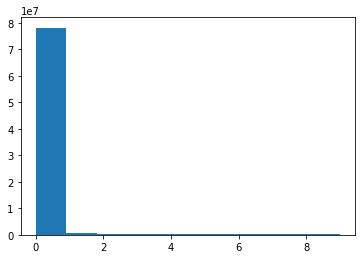

In [8]:
watch_label, *_ = plt.hist(all_df['watch_label'])

In [9]:
watch_label / all_df.shape[0]

array([0.97289031, 0.00694373, 0.0039128 , 0.0027304 , 0.00214762,
       0.00178135, 0.00155826, 0.00146679, 0.00172899, 0.00483976])

In [10]:
# watch_label = Counter(all_df['watch_label'])
watch_label = dict([(i, watch_label[i]) for i in range(len(watch_label))])  # 所有的行为数据集中，watch_label的分布
watch_label

{0: 78100575.0,
 1: 557421.0,
 2: 314107.0,
 3: 219188.0,
 4: 172404.0,
 5: 143001.0,
 6: 125092.0,
 7: 117749.0,
 8: 138798.0,
 9: 388521.0}

array([8.0261906e+07, 1.4950000e+04])

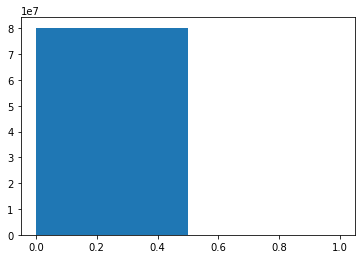

In [11]:
is_share, *_ = plt.hist(all_df['is_share'], bins=2)
is_share

In [20]:
is_share = dict([(i, is_share[i]) for i in range(len(is_share))])  # 所有的行为数据集中，is_share的分布
is_share

{0: 80261906.0, 1: 14950.0}

In [61]:
# 历史行为数据集中存在243个video_id没有在视频特征中出现
idx1 = pd.Index(all_df['video_id'].unique())
idx2 = pd.Index(video_data['video_id'].unique())
idx1.difference(idx2)

Int64Index([], dtype='int64')

In [62]:
# 历史行为数据集中不存在user_id没有在用户特征中出现
idx1 = pd.Index(all_df['user_id'].unique())
idx2 = pd.Index(user_data['user_id'].unique())
idx1.difference(idx2)

Int64Index([], dtype='int64')

## 保存训练数据
将十四天的用户历史行为数据拼接，只保留`[user_id, video_id, is_share, watch_label]`列

In [66]:
all_df = all_df[(all_df['is_watch'] == 1) | (all_df['is_share'] == 1)]

In [67]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7353655 entries, 23933 to 80276855
Data columns (total 6 columns):
 #   Column       Dtype
---  ------       -----
 0   user_id      int64
 1   video_id     int64
 2   is_watch     int64
 3   is_share     int64
 4   watch_label  int64
 5   pt_d         int64
dtypes: int64(6)
memory usage: 392.7 MB


In [68]:
data = all_df.values
columns = all_df.columns.tolist()

In [69]:
data.shape, columns

((7353655, 6),
 ['user_id', 'video_id', 'is_watch', 'is_share', 'watch_label', 'pt_d'])

In [70]:
np.savez(os.path.join(train_data_dir, "all_actions_with_ptd_v1"), data=data, columns=columns)

In [71]:
tab = dt.Frame(all_df)
tab.to_jay(os.path.join(train_data_dir, "all_actions_with_ptd_v1.jay"))

array([[<AxesSubplot:title={'center':'watch_label'}>,
        <AxesSubplot:title={'center':'is_share'}>]], dtype=object)

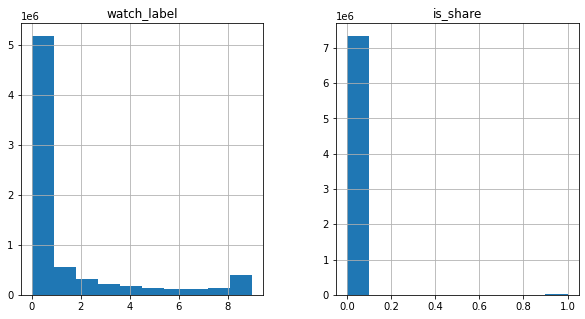

In [49]:
all_df[['watch_label', 'is_share']].hist(figsize=(10,5))

In [75]:
# 平均数编码，代码参考自：https://zhuanlan.zhihu.com/p/26308272
from sklearn.model_selection import StratifiedKFold
from itertools import product

class MeanEncoder:
    def __init__(self, categorical_features, n_splits=5, target_type='classification', prior_weight_func=None):
        """
        :param categorical_features: list of str, the name of the categorical columns to encode

        :param n_splits: the number of splits used in mean encoding

        :param target_type: str, 'regression' or 'classification'

        :param prior_weight_func:
        a function that takes in the number of observations, and outputs prior weight
        when a dict is passed, the default exponential decay function will be used:
        k: the number of observations needed for the posterior to be weighted equally as the prior
        f: larger f --> smaller slope
        """

        self.categorical_features = categorical_features
        self.n_splits = n_splits
        self.learned_stats = {}

        if target_type == 'classification':
            self.target_type = target_type
            self.target_values = []
        else:
            self.target_type = 'regression'
            self.target_values = None

        if isinstance(prior_weight_func, dict):
            self.prior_weight_func = eval('lambda x: 1 / (1 + np.exp((x - k) / f))', dict(prior_weight_func, np=np))
        elif callable(prior_weight_func):
            self.prior_weight_func = prior_weight_func
        else:
            self.prior_weight_func = lambda x: 1 / (1 + np.exp((x - 2) / 1))

    @staticmethod
    def mean_encode_subroutine(X_train, y_train, X_test, variable, target, prior_weight_func):
        X_train = X_train[[variable]].copy()
        X_test = X_test[[variable]].copy()

        if target is not None:
            nf_name = '{}_pred_{}'.format(variable, target)
            X_train['pred_temp'] = (y_train == target).astype(int)  # classification
        else:
            nf_name = '{}_pred'.format(variable)
            X_train['pred_temp'] = y_train  # regression
        prior = X_train['pred_temp'].mean()
        
        col_avg_y = X_train.groupby(variable)['pred_temp'].agg(['mean','size']).rename(columns={'mean':'mean','size':'beta'})
#         col_avg_y = X_train.groupby(by=variable, axis=0)['pred_temp'].agg({'mean': 'mean', 'beta': 'size'})
        col_avg_y['beta'] = prior_weight_func(col_avg_y['beta'])
        col_avg_y[nf_name] = col_avg_y['beta'] * prior + (1 - col_avg_y['beta']) * col_avg_y['mean']
        col_avg_y.drop(['beta', 'mean'], axis=1, inplace=True)

        nf_train = X_train.join(col_avg_y, on=variable)[nf_name].values
        nf_test = X_test.join(col_avg_y, on=variable).fillna(prior, inplace=False)[nf_name].values

        return nf_train, nf_test, prior, col_avg_y

    def fit_transform(self, X, y):
        """
        :param X: pandas DataFrame, n_samples * n_features
        :param y: pandas Series or numpy array, n_samples
        :return X_new: the transformed pandas DataFrame containing mean-encoded categorical features
        """
        X_new = X.copy()
        if self.target_type == 'classification':
            skf = StratifiedKFold(self.n_splits)
        else:
            skf = KFold(self.n_splits)

        if self.target_type == 'classification':
            self.target_values = sorted(set(y))
            self.learned_stats = {'{}_pred_{}'.format(variable, target): [] for variable, target in
                                  product(self.categorical_features, self.target_values)}
            for variable, target in product(self.categorical_features, self.target_values):
                nf_name = '{}_pred_{}'.format(variable, target)
                X_new.loc[:, nf_name] = np.nan
                for large_ind, small_ind in skf.split(y, y):
                    nf_large, nf_small, prior, col_avg_y = MeanEncoder.mean_encode_subroutine(
                        X_new.iloc[large_ind], y.iloc[large_ind], X_new.iloc[small_ind], variable, target, self.prior_weight_func)
                    X_new.iloc[small_ind, -1] = nf_small
                    self.learned_stats[nf_name].append((prior, col_avg_y))
        else:
            self.learned_stats = {'{}_pred'.format(variable): [] for variable in self.categorical_features}
            for variable in self.categorical_features:
                nf_name = '{}_pred'.format(variable)
                X_new.loc[:, nf_name] = np.nan
                for large_ind, small_ind in skf.split(y, y):
                    nf_large, nf_small, prior, col_avg_y = MeanEncoder.mean_encode_subroutine(
                        X_new.iloc[large_ind], y.iloc[large_ind], X_new.iloc[small_ind], variable, None, self.prior_weight_func)
                    X_new.iloc[small_ind, -1] = nf_small
                    self.learned_stats[nf_name].append((prior, col_avg_y))
        return X_new

    def transform(self, X):
        """
        :param X: pandas DataFrame, n_samples * n_features
        :return X_new: the transformed pandas DataFrame containing mean-encoded categorical features
        """
        X_new = X.copy()

        if self.target_type == 'classification':
            for variable, target in product(self.categorical_features, self.target_values):
                nf_name = '{}_pred_{}'.format(variable, target)
                X_new[nf_name] = 0
                for prior, col_avg_y in self.learned_stats[nf_name]:
                    X_new[nf_name] += X_new[[variable]].join(col_avg_y, on=variable).fillna(prior, inplace=False)[
                        nf_name]
                X_new[nf_name] /= self.n_splits
        else:
            for variable in self.categorical_features:
                nf_name = '{}_pred'.format(variable)
                X_new[nf_name] = 0
                for prior, col_avg_y in self.learned_stats[nf_name]:
                    X_new[nf_name] += X_new[[variable]].join(col_avg_y, on=variable).fillna(prior, inplace=False)[
                        nf_name]
                X_new[nf_name] /= self.n_splits

        return X_new


In [76]:
me = MeanEncoder(['city', 'device_name'])
y = np.random.randint(0, 10, user_data.shape[0])

In [ ]:
X_new = me.fit_transform(user_data, pd.Series(y))

In [82]:
X_new.columns

Index(['user_id', 'age', 'gender', 'country', 'province', 'city', 'city_level',
       'device_name', 'city_pred_0', 'city_pred_1', 'city_pred_2',
       'city_pred_3', 'city_pred_4', 'city_pred_5', 'city_pred_6',
       'city_pred_7', 'city_pred_8', 'city_pred_9', 'device_name_pred_0',
       'device_name_pred_1', 'device_name_pred_2', 'device_name_pred_3',
       'device_name_pred_4', 'device_name_pred_5', 'device_name_pred_6',
       'device_name_pred_7', 'device_name_pred_8', 'device_name_pred_9'],
      dtype='object')

In [79]:
user_data

,user_id,age,gender,country,province,city,city_level,device_name
0,1757005,3,1,0,9,6,3,327
1,17938,0,0,0,4,22,3,327
2,4263520,1,0,0,19,1,5,327
3,1411600,3,0,0,5,138,1,327
4,3992242,2,0,0,0,142,0,327
...,...,...,...,...,...,...,...,...
5910795,3223427,4,0,0,3,3,3,28
5910796,4707826,4,0,0,17,249,1,28
5910797,5907653,0,0,0,11,65,0,28
5910798,3633224,3,0,0,2,57,1,28
